In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/taxi_clean.csv')
df = df.dropna()

In [3]:
def corr_highlight(cell):
    highlight = 'background-color: darkorange;'
    default = ''
    if type(cell) in [float, int]:
        if cell >= 0.9 and cell != 1:
            return highlight
        return default

corrtbl = df.corr().abs()
corrtbl = corrtbl.iloc[4:,4:]
corrtbl = corrtbl.style.applymap(corr_highlight)
corrtbl

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,day_of_week,day_of_month,hour_of_day,trip_duration,total_without_tip,fare_per_mile
passenger_count,1.000000,0.021590,0.022303,0.021908,0.004932,0.005806,0.011111,0.006232,0.018095,0.005751,0.004146,0.031171,0.019278,0.020509,0.040848,0.011009,0.018020,0.000514
trip_distance,0.021590,1.000000,0.925387,0.001624,0.040657,0.196647,0.608561,0.050845,0.917000,0.175209,0.048456,0.043460,0.007885,0.001906,0.035655,0.148440,0.929305,0.052687
fare_amount,0.022303,0.925387,1.000000,0.003971,0.040182,0.200605,0.556802,0.073033,0.979271,0.197215,0.053913,0.035779,0.002688,0.000577,0.019713,0.158437,0.993964,0.036188
extra,0.021908,0.001624,0.003971,1.000000,0.107925,0.082978,0.029265,0.054185,0.048214,0.064628,0.096973,0.236607,0.115133,0.008140,0.268154,0.011236,0.036864,0.017458
mta_tax,0.004932,0.040657,0.040182,0.107925,1.000000,0.005188,0.016458,0.516927,0.022813,0.101812,0.872987,0.075886,0.029974,0.008959,0.022047,0.007358,0.023070,0.143011
tip_amount,0.005806,0.196647,0.200605,0.082978,0.005188,1.000000,0.109167,0.032153,0.367547,0.471156,0.011654,0.271503,0.007752,0.023186,0.021512,0.022692,0.220339,0.002827
tolls_amount,0.011111,0.608561,0.556802,0.029265,0.016458,0.109167,1.000000,0.032640,0.602743,0.113891,0.010839,0.066337,0.001693,0.002359,0.036965,0.086704,0.614150,0.016513
improvement_surcharge,0.006232,0.050845,0.073033,0.054185,0.516927,0.032153,0.032640,1.000000,0.076741,0.140645,0.241637,0.041152,0.007066,0.012381,0.026958,0.003988,0.075179,0.049002
total_amount,0.018095,0.917000,0.979271,0.048214,0.022813,0.367547,0.602743,0.076741,1.000000,0.277035,0.037455,0.142001,0.004590,0.004440,0.006584,0.153163,0.988134,0.027108
payment_type,0.005751,0.175209,0.197215,0.064628,0.101812,0.471156,0.113891,0.140645,0.277035,1.000000,0.053817,0.194110,0.008014,0.013736,0.022511,0.024544,0.212749,0.001065


Using the analysis from the tip_analysis notebook, we see that trip distance and total fare amount are the best correlated features with tip amount. But, in the above table, we can see that the total fare amount and trip distance features themselves are highly correlated. So, to avoid issues of colinearity, I will omit trip distance from our design matrix when creating our model. In addition, I will add features trip duration, hour of day, and payment type, as they are the next three most highly correlated features with tip amount that are not colinear with each other. For context, I am using a correlation coefficient threshhold of 0.9 to determine whether or not two features are likely to be highly colinear or not. 

In [4]:
features = ["fare_amount", "trip_duration", "hour_of_day", "payment_type"]
X = df.loc[:, features].dropna()
y = df['tip_amount']
model1 = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
model1.fit(X_train, y_train)
sm_1 = sm.add_constant(X_train)
estimates = sm.OLS(y_train, sm_1).fit(cov_type = "HC1")
results_summ = estimates.summary().tables[1]
print(results_summ)

                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.2451      0.088     48.027      0.000       4.072       4.418
fare_amount       0.0211      0.004      5.231      0.000       0.013       0.029
trip_duration -1.825e-06   2.47e-06     -0.738      0.461   -6.67e-06    3.02e-06
hour_of_day       0.0063      0.002      2.920      0.004       0.002       0.010
payment_type     -2.2534      0.022   -103.339      0.000      -2.296      -2.211


In [6]:
model1pred = model1.predict(X_test)
model1rmse = np.sqrt(np.mean((model1pred - y_test)**2))
model1rmse

2.0645248172212045

In [7]:
df2 = df.loc[:, ["fare_amount", "trip_duration", "hour_of_day", "payment_type", "tip_amount"]]
df2log = np.log(df2).dropna()
df2log = df2log[~df2log.isin([np.nan, np.inf, -np.inf]).any(1)]
X2 = df2log.loc[:, features].dropna()
y2 = df2log['tip_amount']
model2 = LinearRegression()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [8]:
model2.fit(X_train2, y_train2)
sm_2 = sm.add_constant(X_train2)
estimates2 = sm.OLS(y_train2, sm_2).fit(cov_type = "HC1")
results_summ2 = estimates2.summary().tables[1]
print(results_summ2)

                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1455      0.085    -13.557      0.000      -1.311      -0.980
fare_amount       0.7344      0.023     32.376      0.000       0.690       0.779
trip_duration     0.0289      0.019      1.532      0.125      -0.008       0.066
hour_of_day       0.0286      0.011      2.649      0.008       0.007       0.050
payment_type           0          0        nan        nan           0           0


In [9]:
model2pred = model2.predict(X_test2)
model2rmse = np.sqrt(np.mean((model2pred - y_test2)**2))
model2rmse

0.6293757450434577

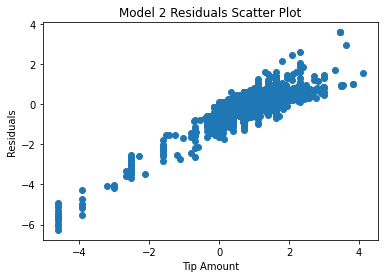

In [10]:
errors_model2 = y_test2 - model2pred
plt.scatter(y_test2, errors_model2)
plt.title("Model 2 Residuals Scatter Plot")
plt.ylabel("Residuals")
plt.xlabel("Tip Amount")
plt.show();

Using a linear regression model for predicting the tip amount was not a good decision, because the scatter plot of the residuals showed a clear pattern. When using the same features with log, we not only get a lower RMSE, but a more abstract residual plot, showing us that a log-log model gives us more accurate results.